First cluster


In [3]:
%load_ext autoreload
%matplotlib inline

In [4]:
%autoreload 2
from model import *
from load_data import *
from utils import *

88.3% of data retained after cleaning


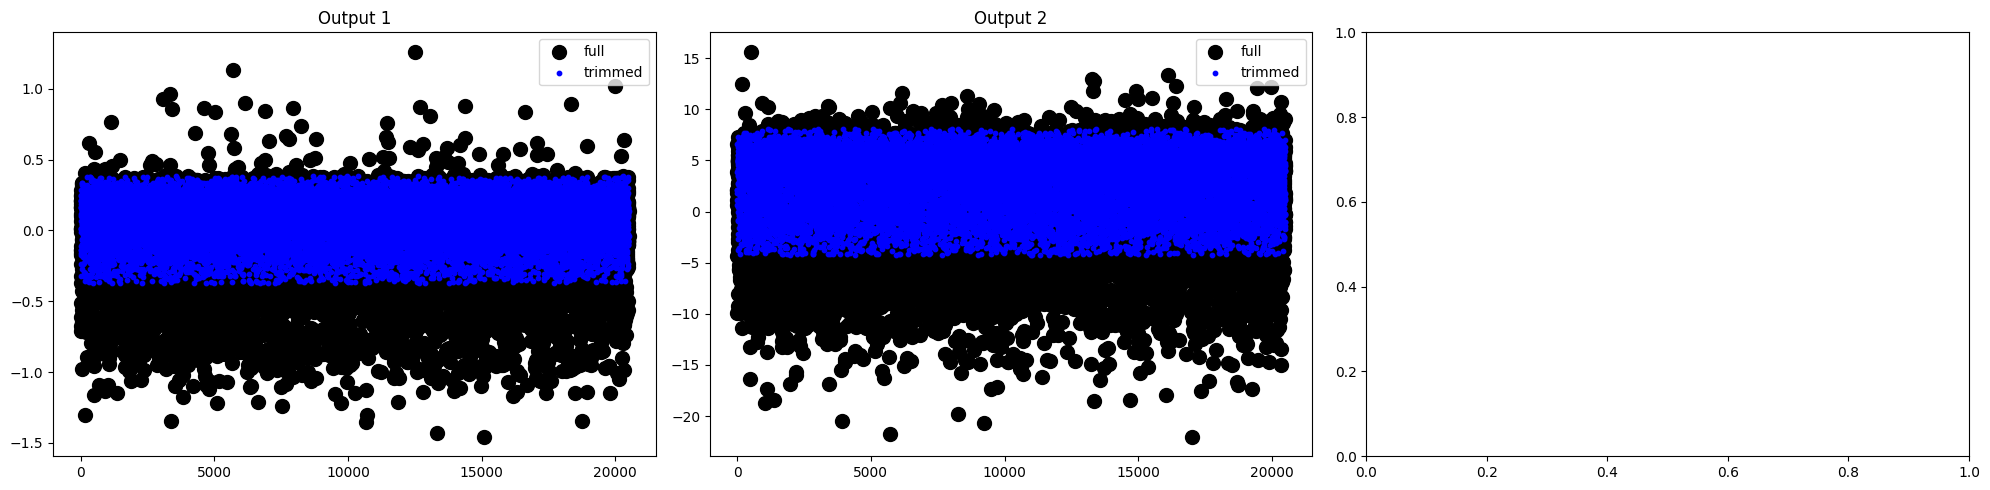

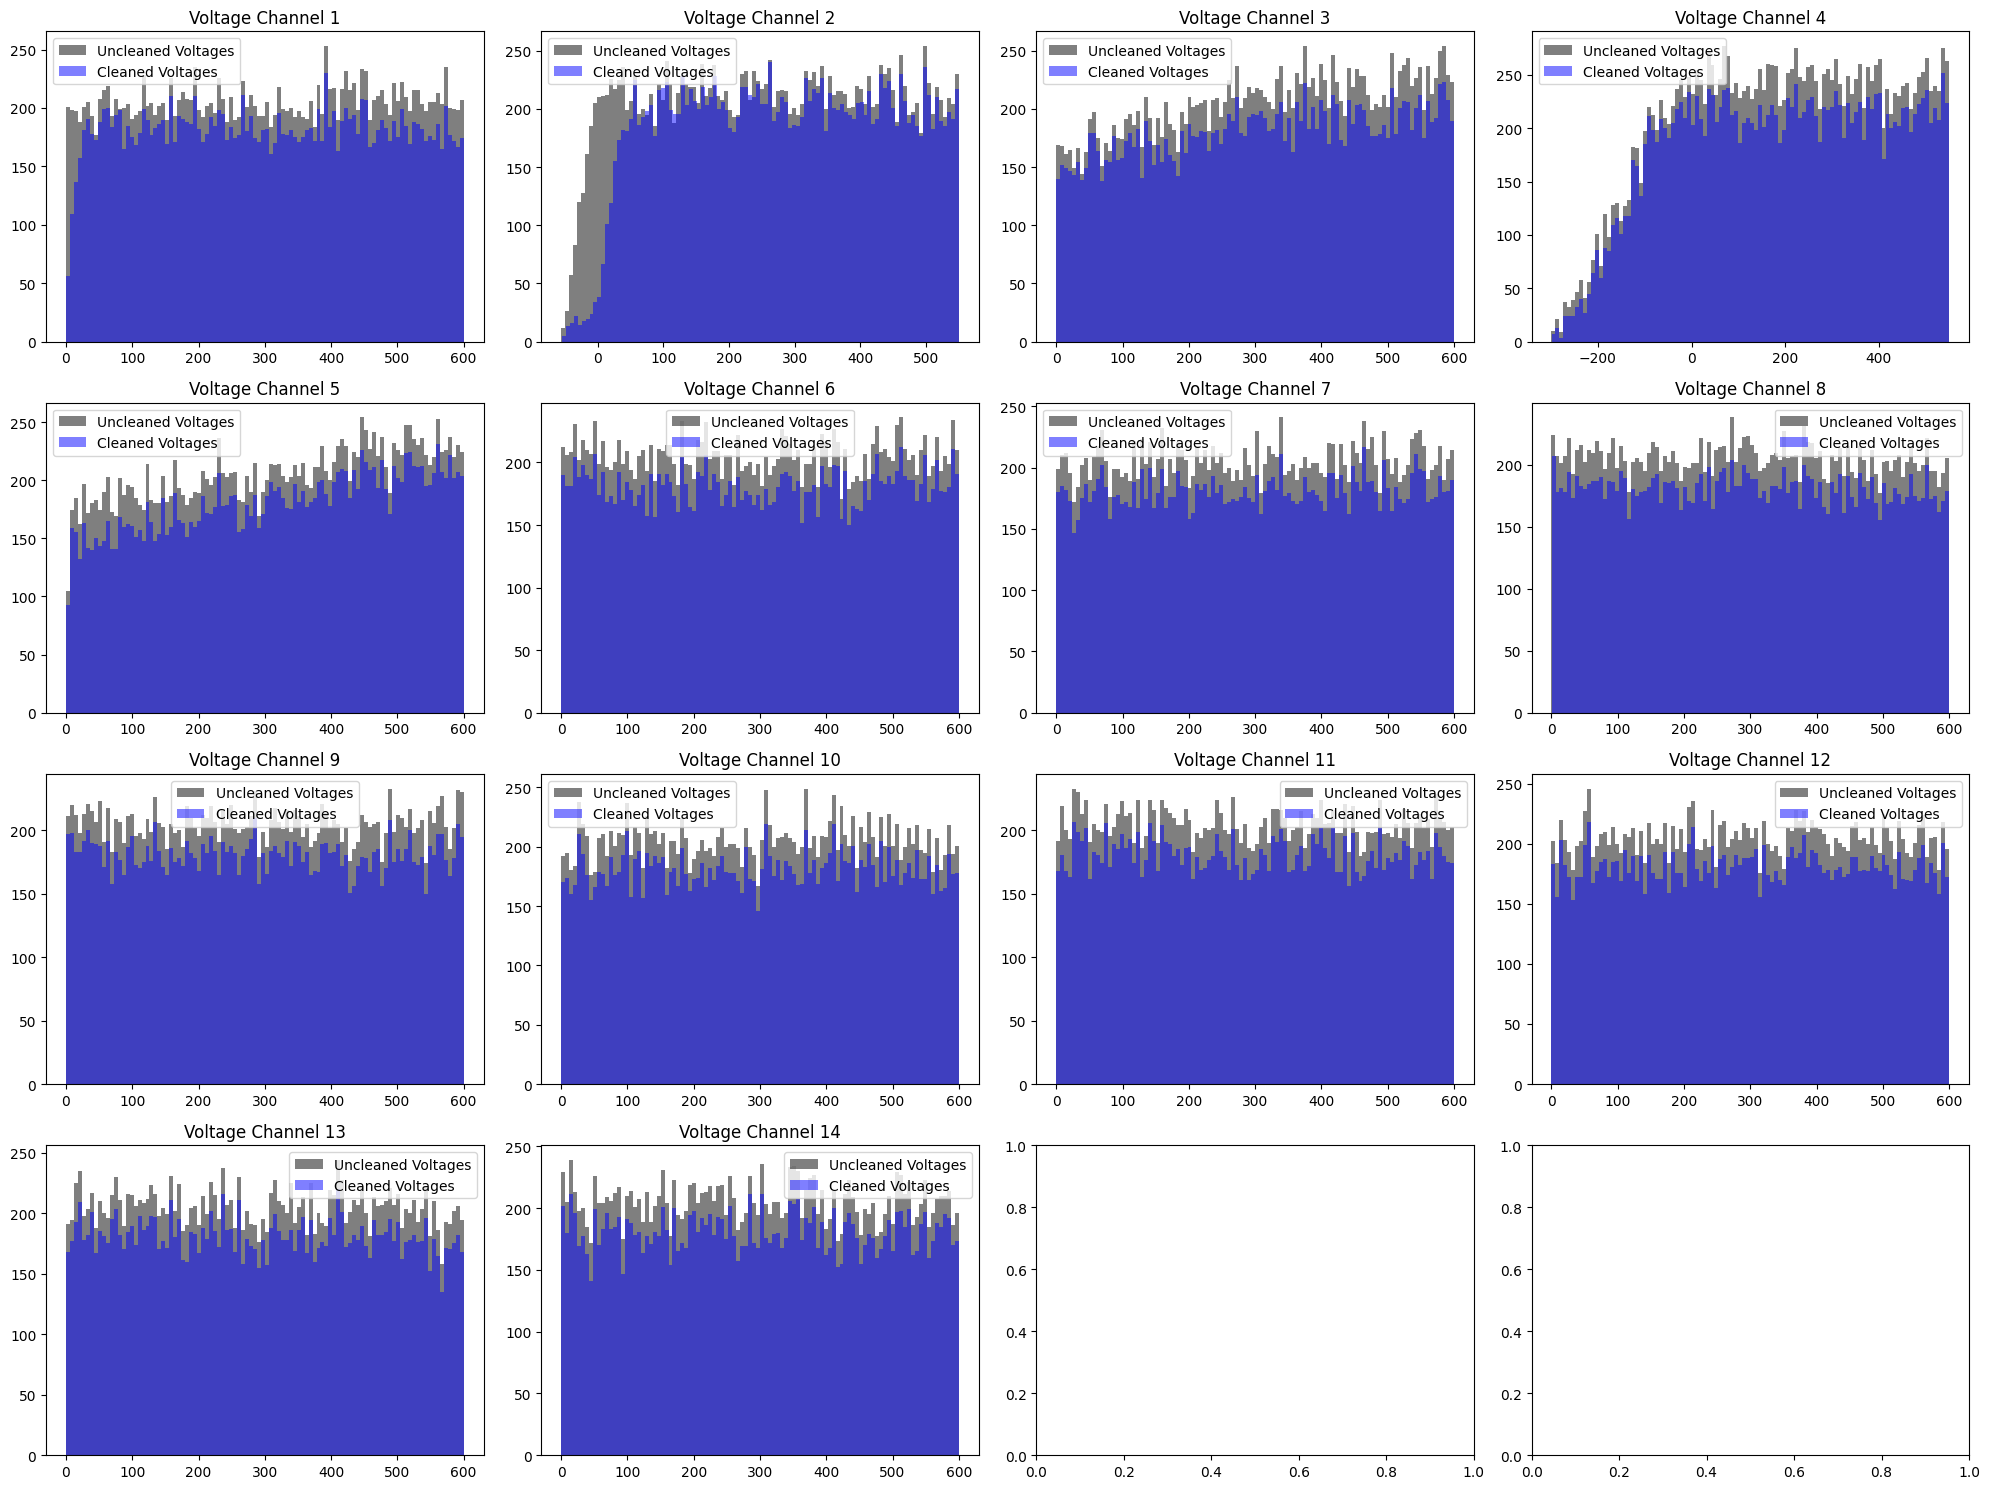

In [ ]:
threshold = 1.5
_,ax,_,_,_,_=trim_scatter(["test_model_data.csv","parallel_test_model_data.csv"], output_values_start=14, output_values_end=15,trim_threshold=threshold,subplot_shape=(1,3),figsize=(20, 5))
# ax[0].set_xlim(0, 100)
# ax[0].set_ylim(-5, 5)
_,_,_,_,fig,ax=trim_hist(['test_model_data.csv','parallel_test_model_data.csv'], output_values_start=14, output_values_end=15,trim_threshold=threshold,subplot_shape=(4,4))


Using device: mps
Training model...
Epoch 0: Train Loss = 0.296648, Val Loss = 0.040686
Training completed. Best validation loss: 0.008639


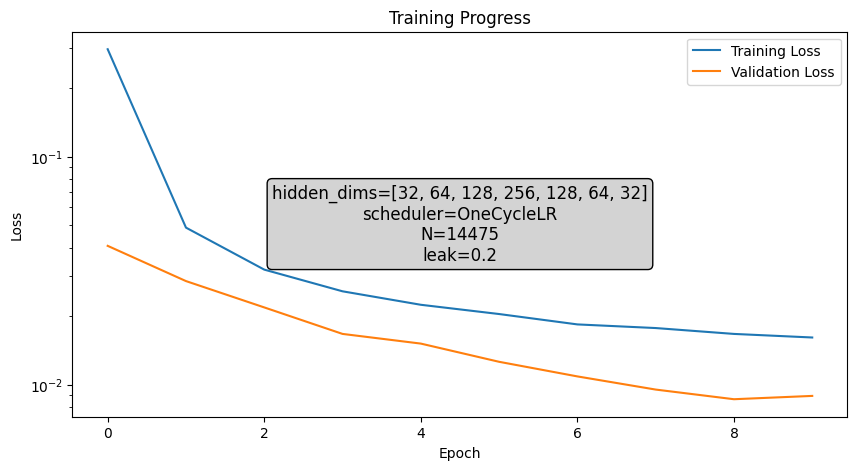

In [ ]:

n_voltages = 14     # Number of voltage parameters
n_output_values = 2 # Number of output values (e.g., magnification, aberration, etc.)
voltages, output_values =load_data(['parallel_test_model_data.csv','test_model_data.csv'], output_values_start=14, output_values_end=15,trim_threshold=threshold)
# Create and train model
predictor1 = ElectronOpticsPredictor(input_dim=n_voltages, output_dim=n_output_values,leak=0.2)
print("Training model...")
predictor1.train(voltages, output_values, epochs=10, verbose=True,weight_name='best_model1.pth')


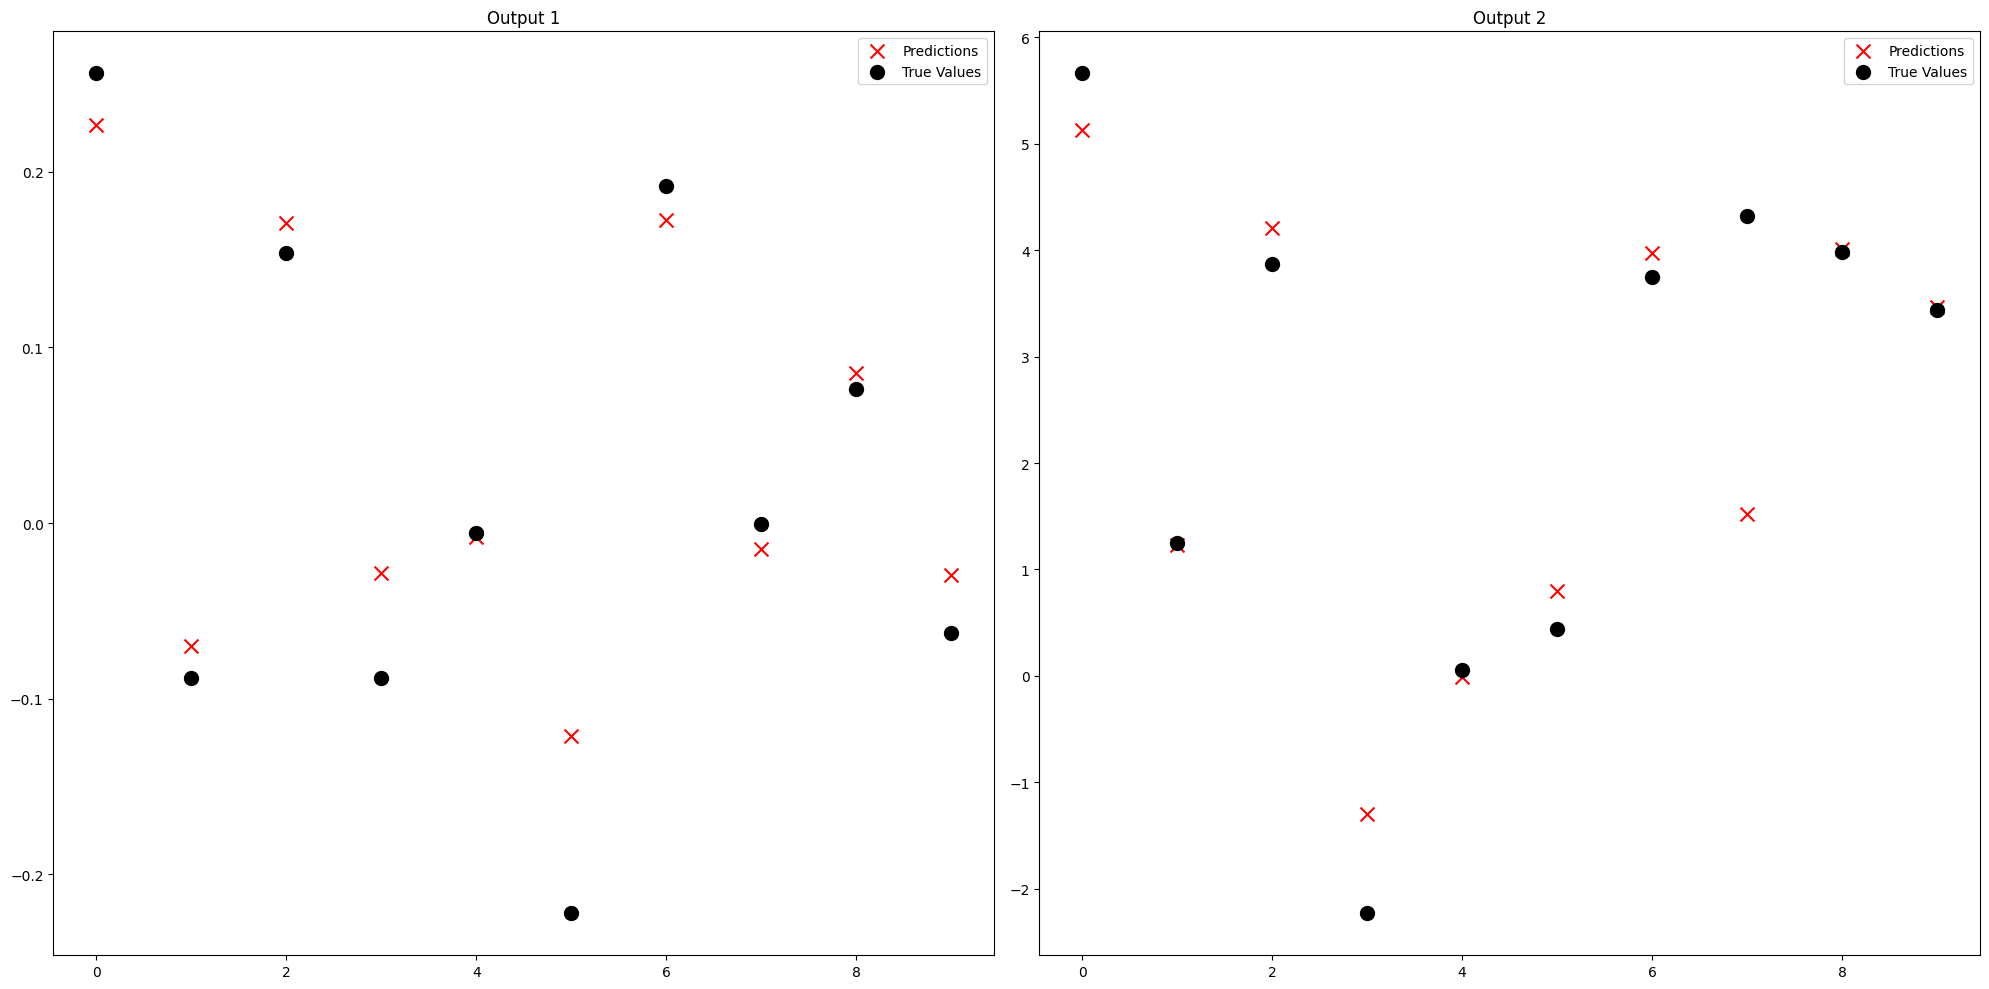

In [ ]:
_,_,all_predictions, all_true_values =plot_inference_comparison(predictor1,n_samples=10,subplot_shape=(1,2))

cluster 2

94.5% of data retained after cleaning


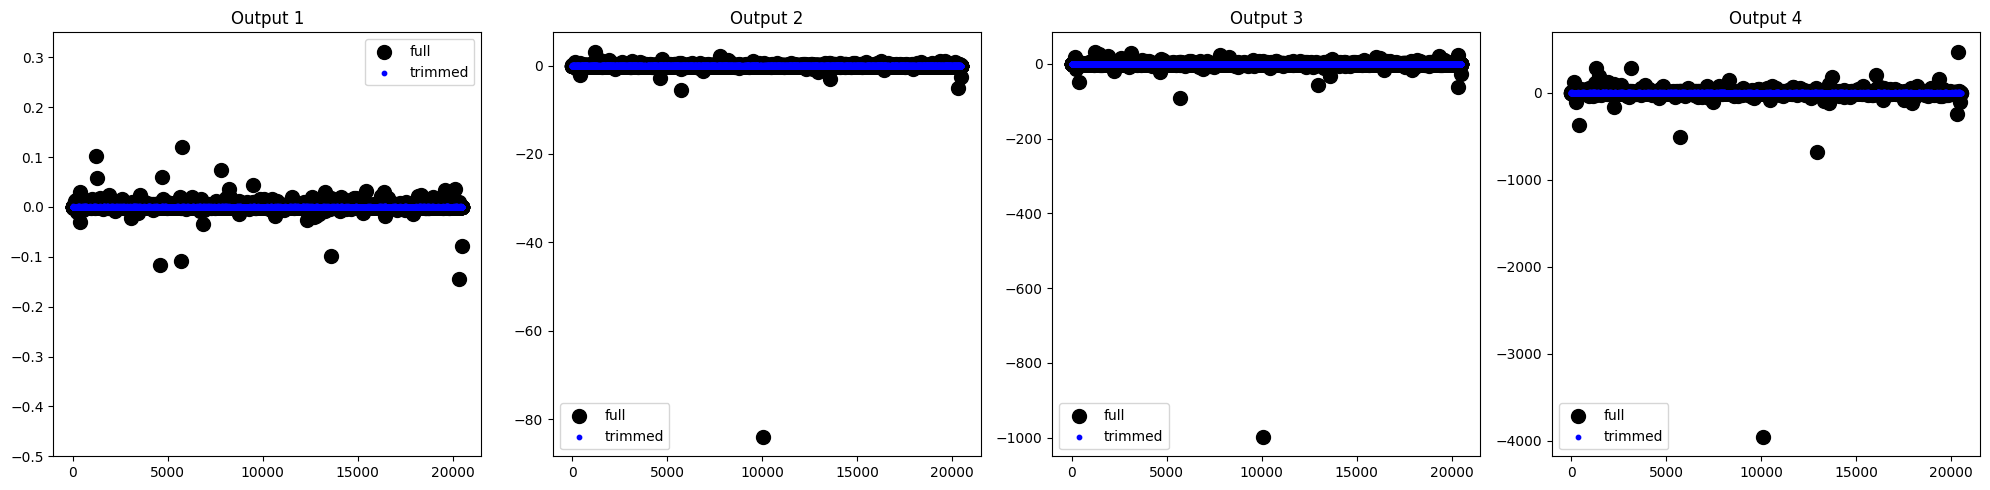

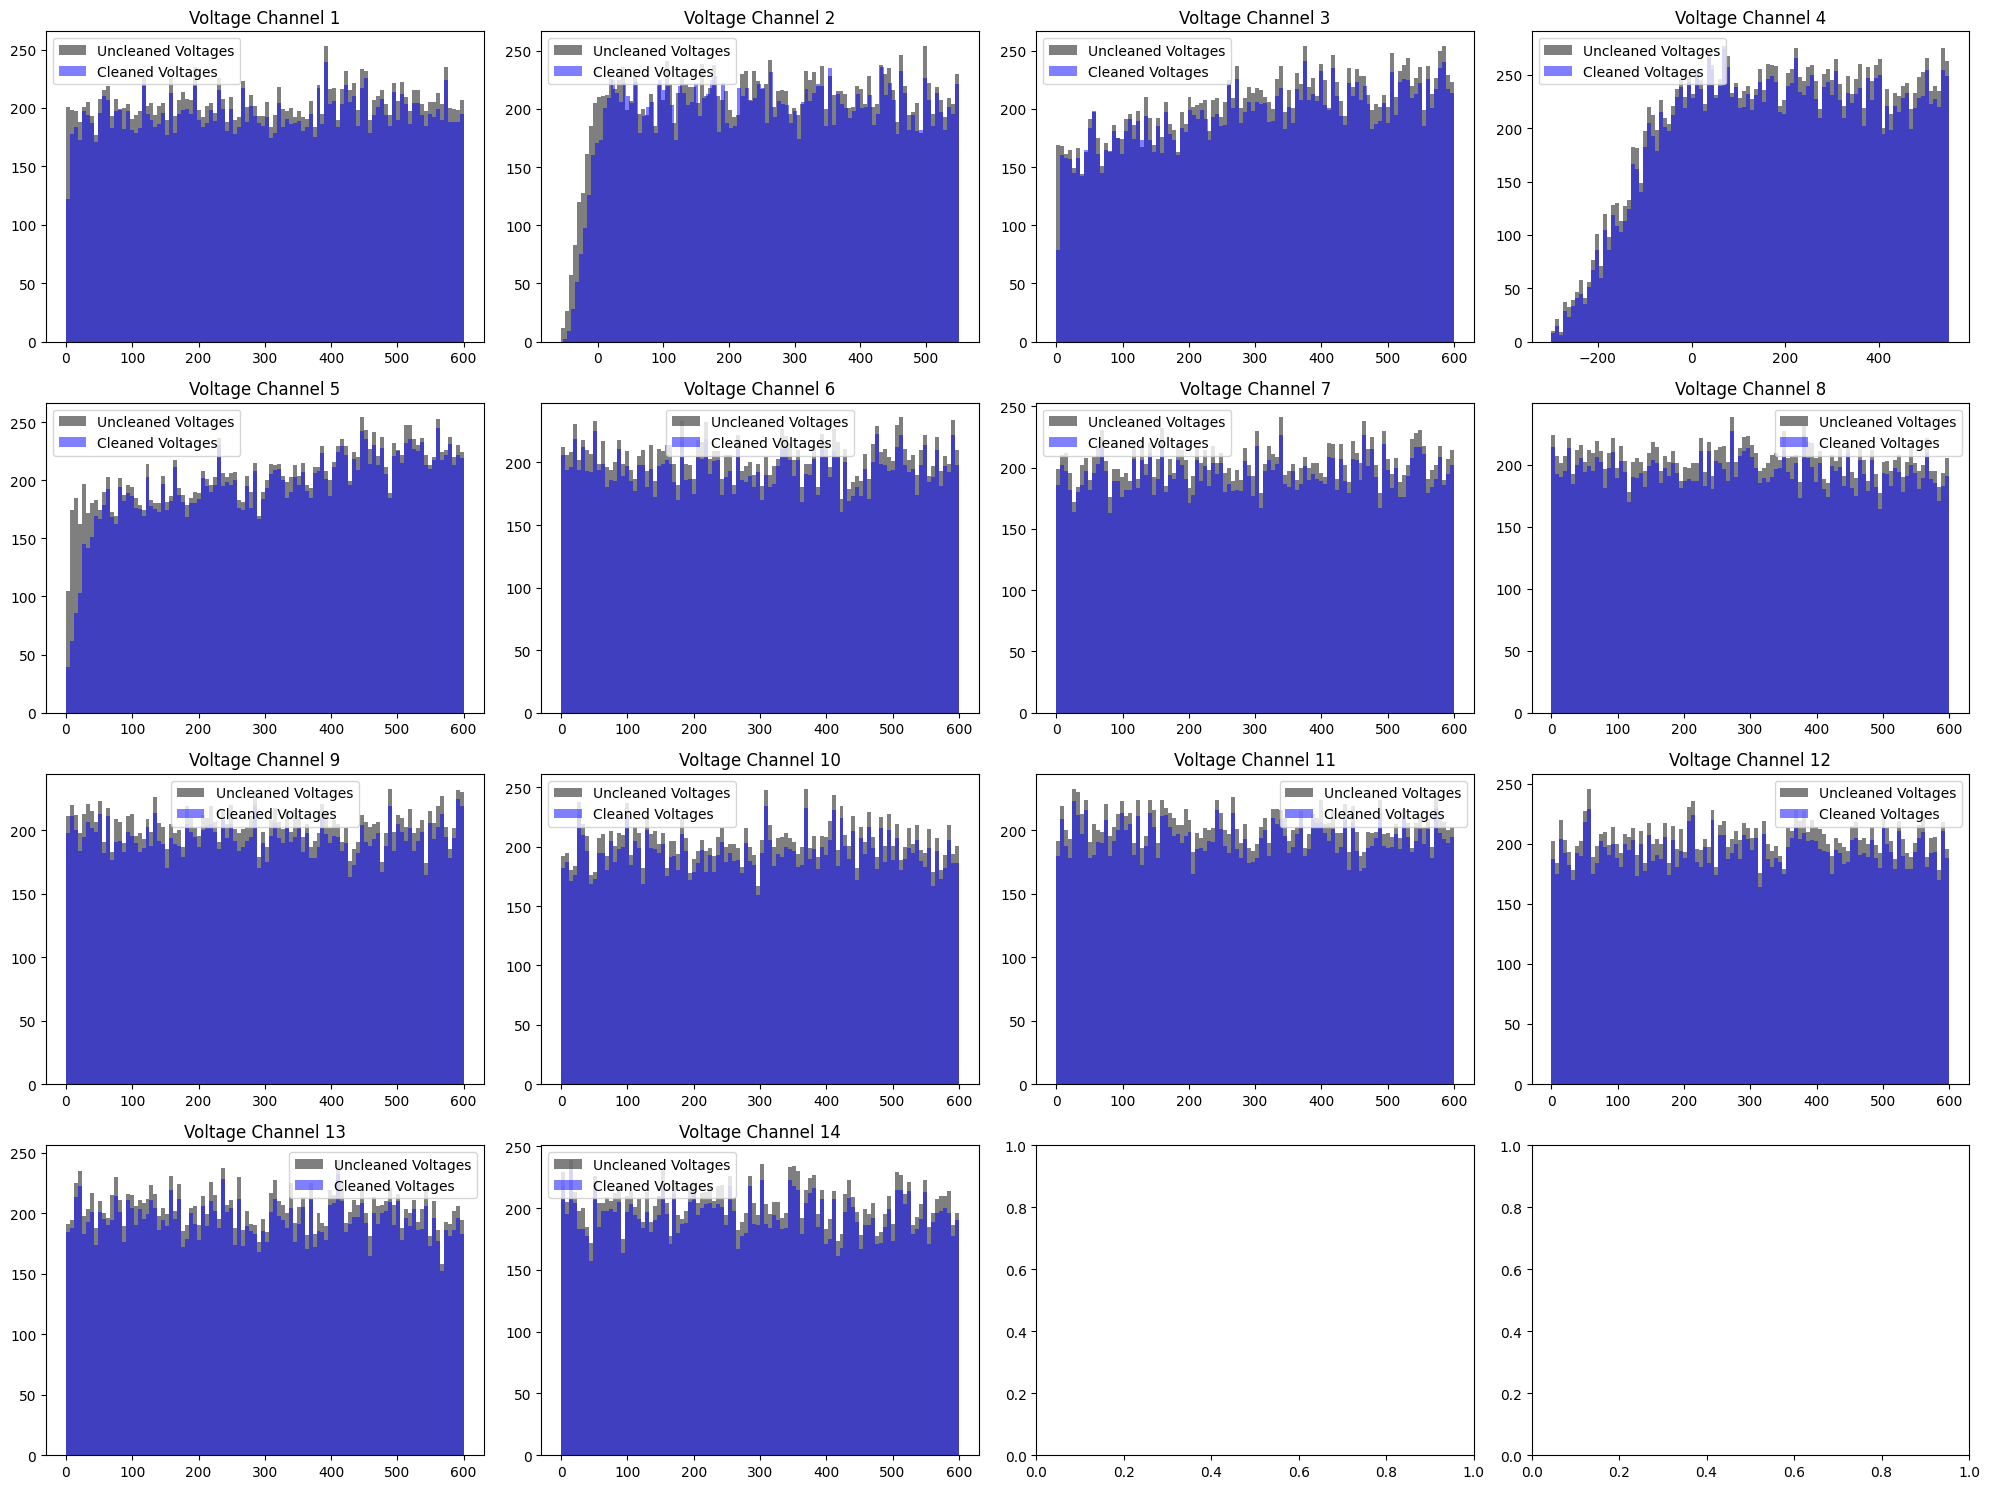

In [ ]:
threshold = 0.1
_,ax,_,_,_,_=trim_scatter(["test_model_data.csv","parallel_test_model_data.csv"], output_values_start=16, output_values_end=19,trim_threshold=threshold,subplot_shape=(1,4),figsize=(20, 5))
# ax[0].set_xlim(0, 100)

ax[0].set_ylim(-0.5, 0.35)
_,_,_,_,fig,ax=trim_hist(['test_model_data.csv','parallel_test_model_data.csv'], output_values_start=16, output_values_end=19,trim_threshold=threshold,subplot_shape=(4,4))


Using device: mps
Training model...
Epoch 0: Train Loss = 0.144016, Val Loss = 0.006692
Training completed. Best validation loss: 0.003846


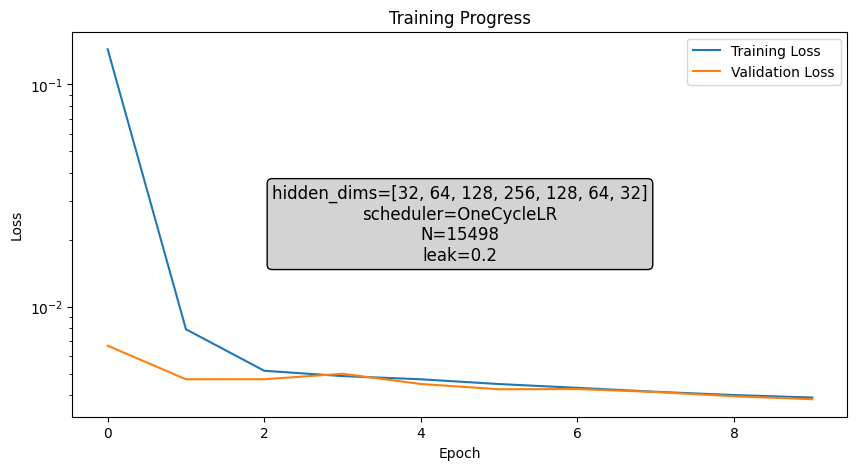

In [250]:

n_voltages = 14     # Number of voltage parameters
n_output_values = 4 # Number of output values (e.g., magnification, aberration, etc.)
voltages, output_values =load_data(['parallel_test_model_data.csv','test_model_data.csv'], output_values_start=16, output_values_end=19,trim_threshold=threshold)
# Create and train model
predictor2 = ElectronOpticsPredictor(input_dim=n_voltages, output_dim=n_output_values,leak=0.2)
print("Training model...")
predictor2.train(voltages, output_values, epochs=10, verbose=True,weight_name='best_model2.pth')


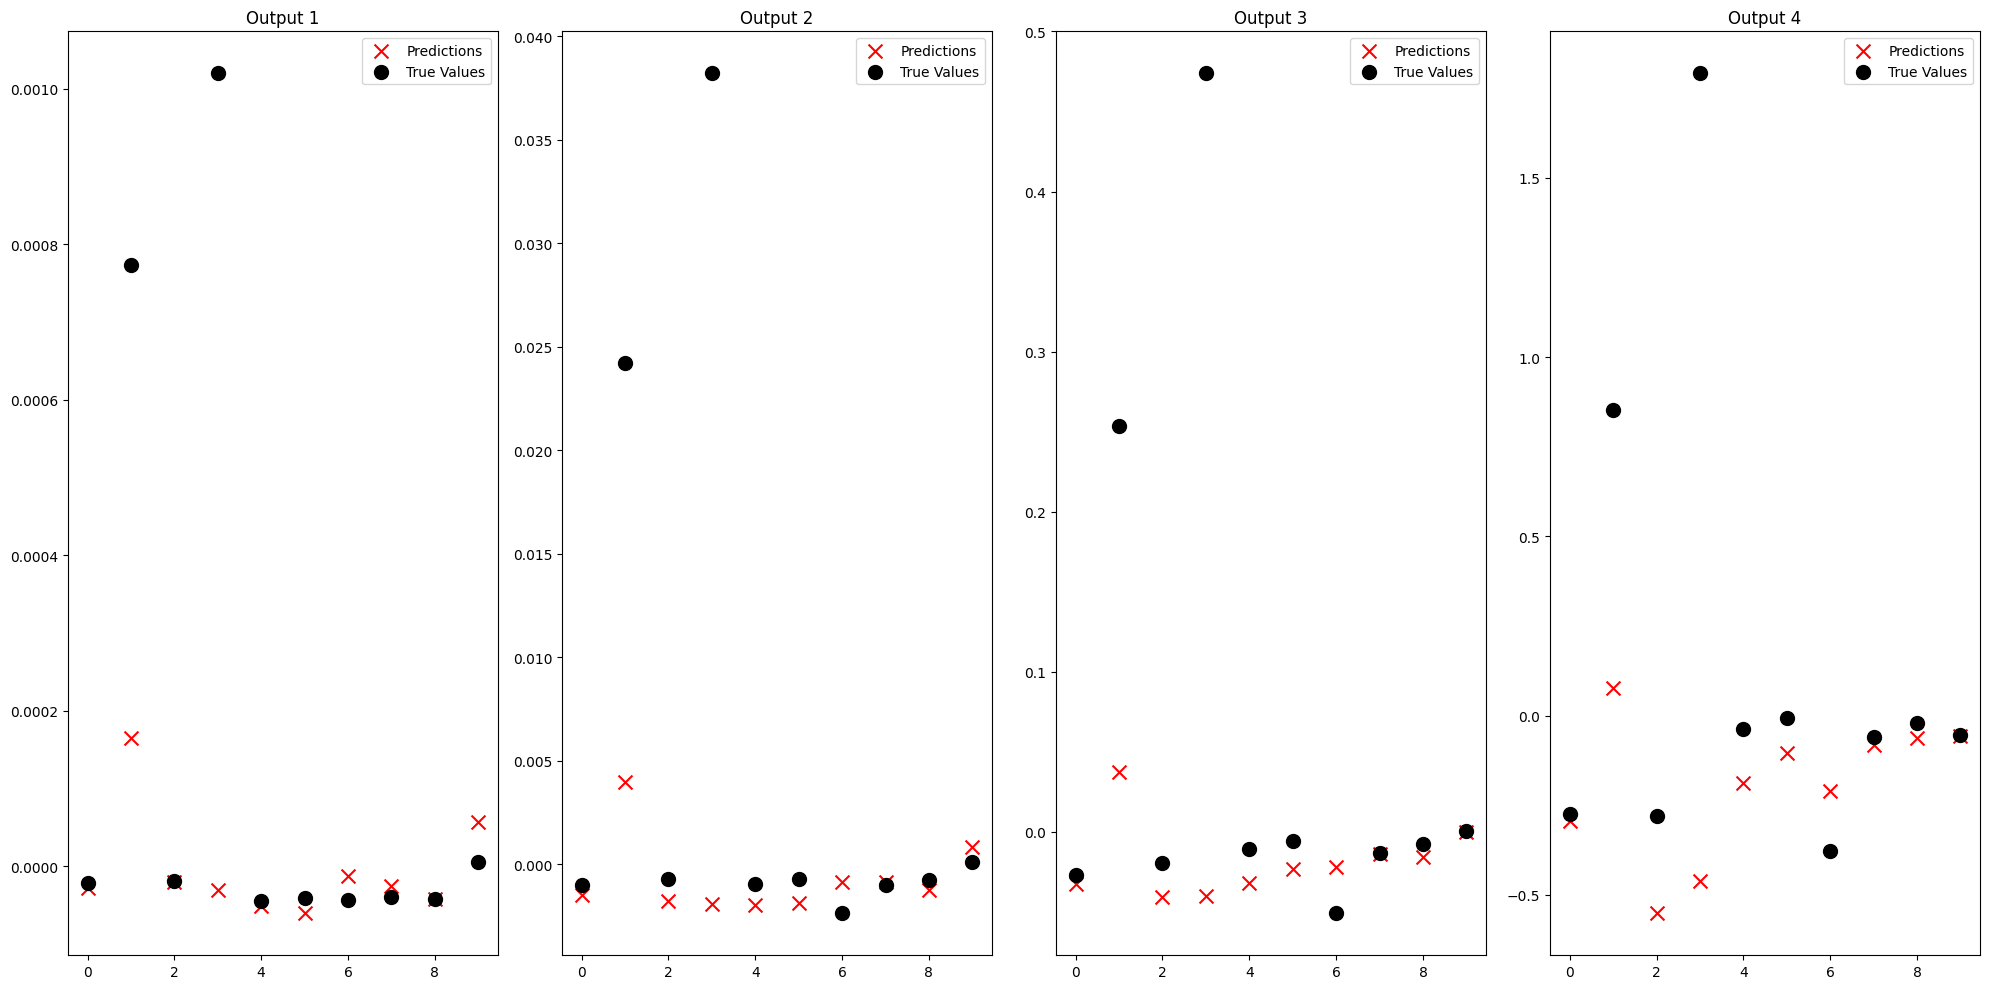

In [252]:
_,_,all_predictions, all_true_values =plot_inference_comparison(predictor2,n_samples=10,subplot_shape=(1,4))

Cluster 3

91.2% of data retained after cleaning


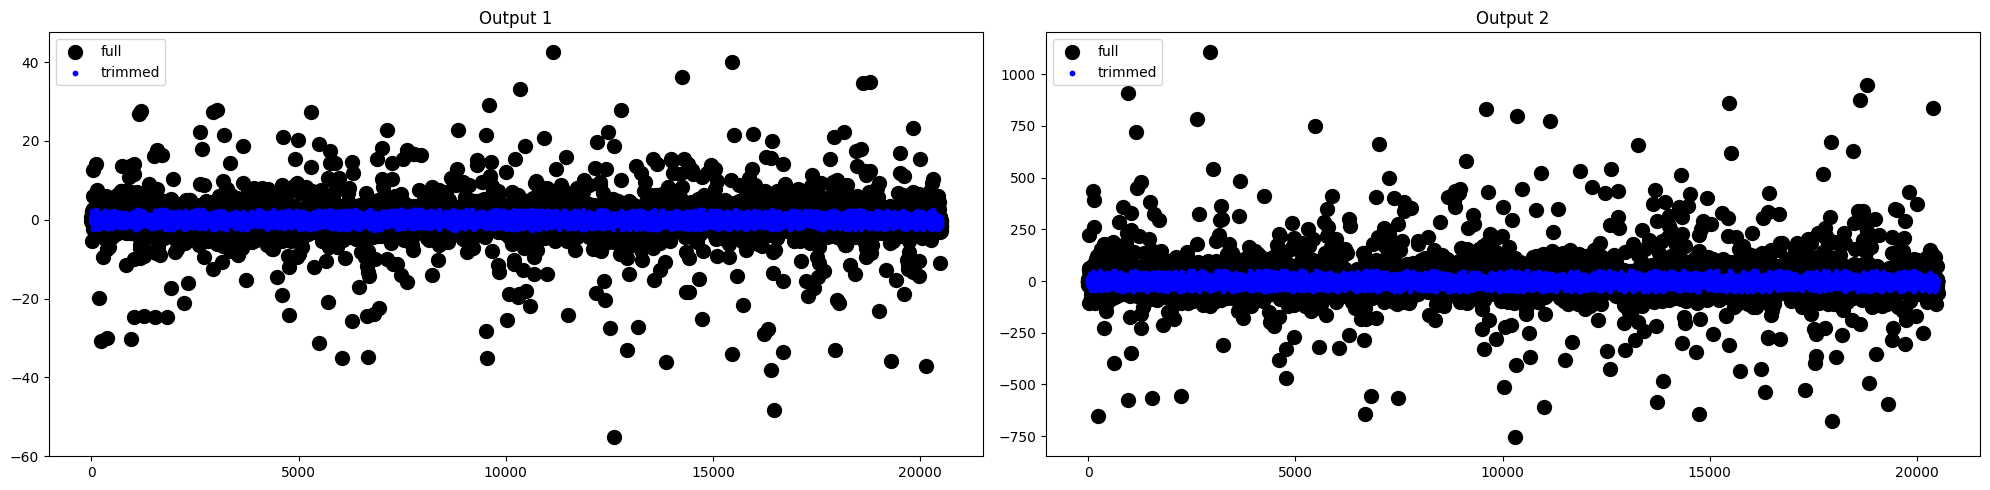

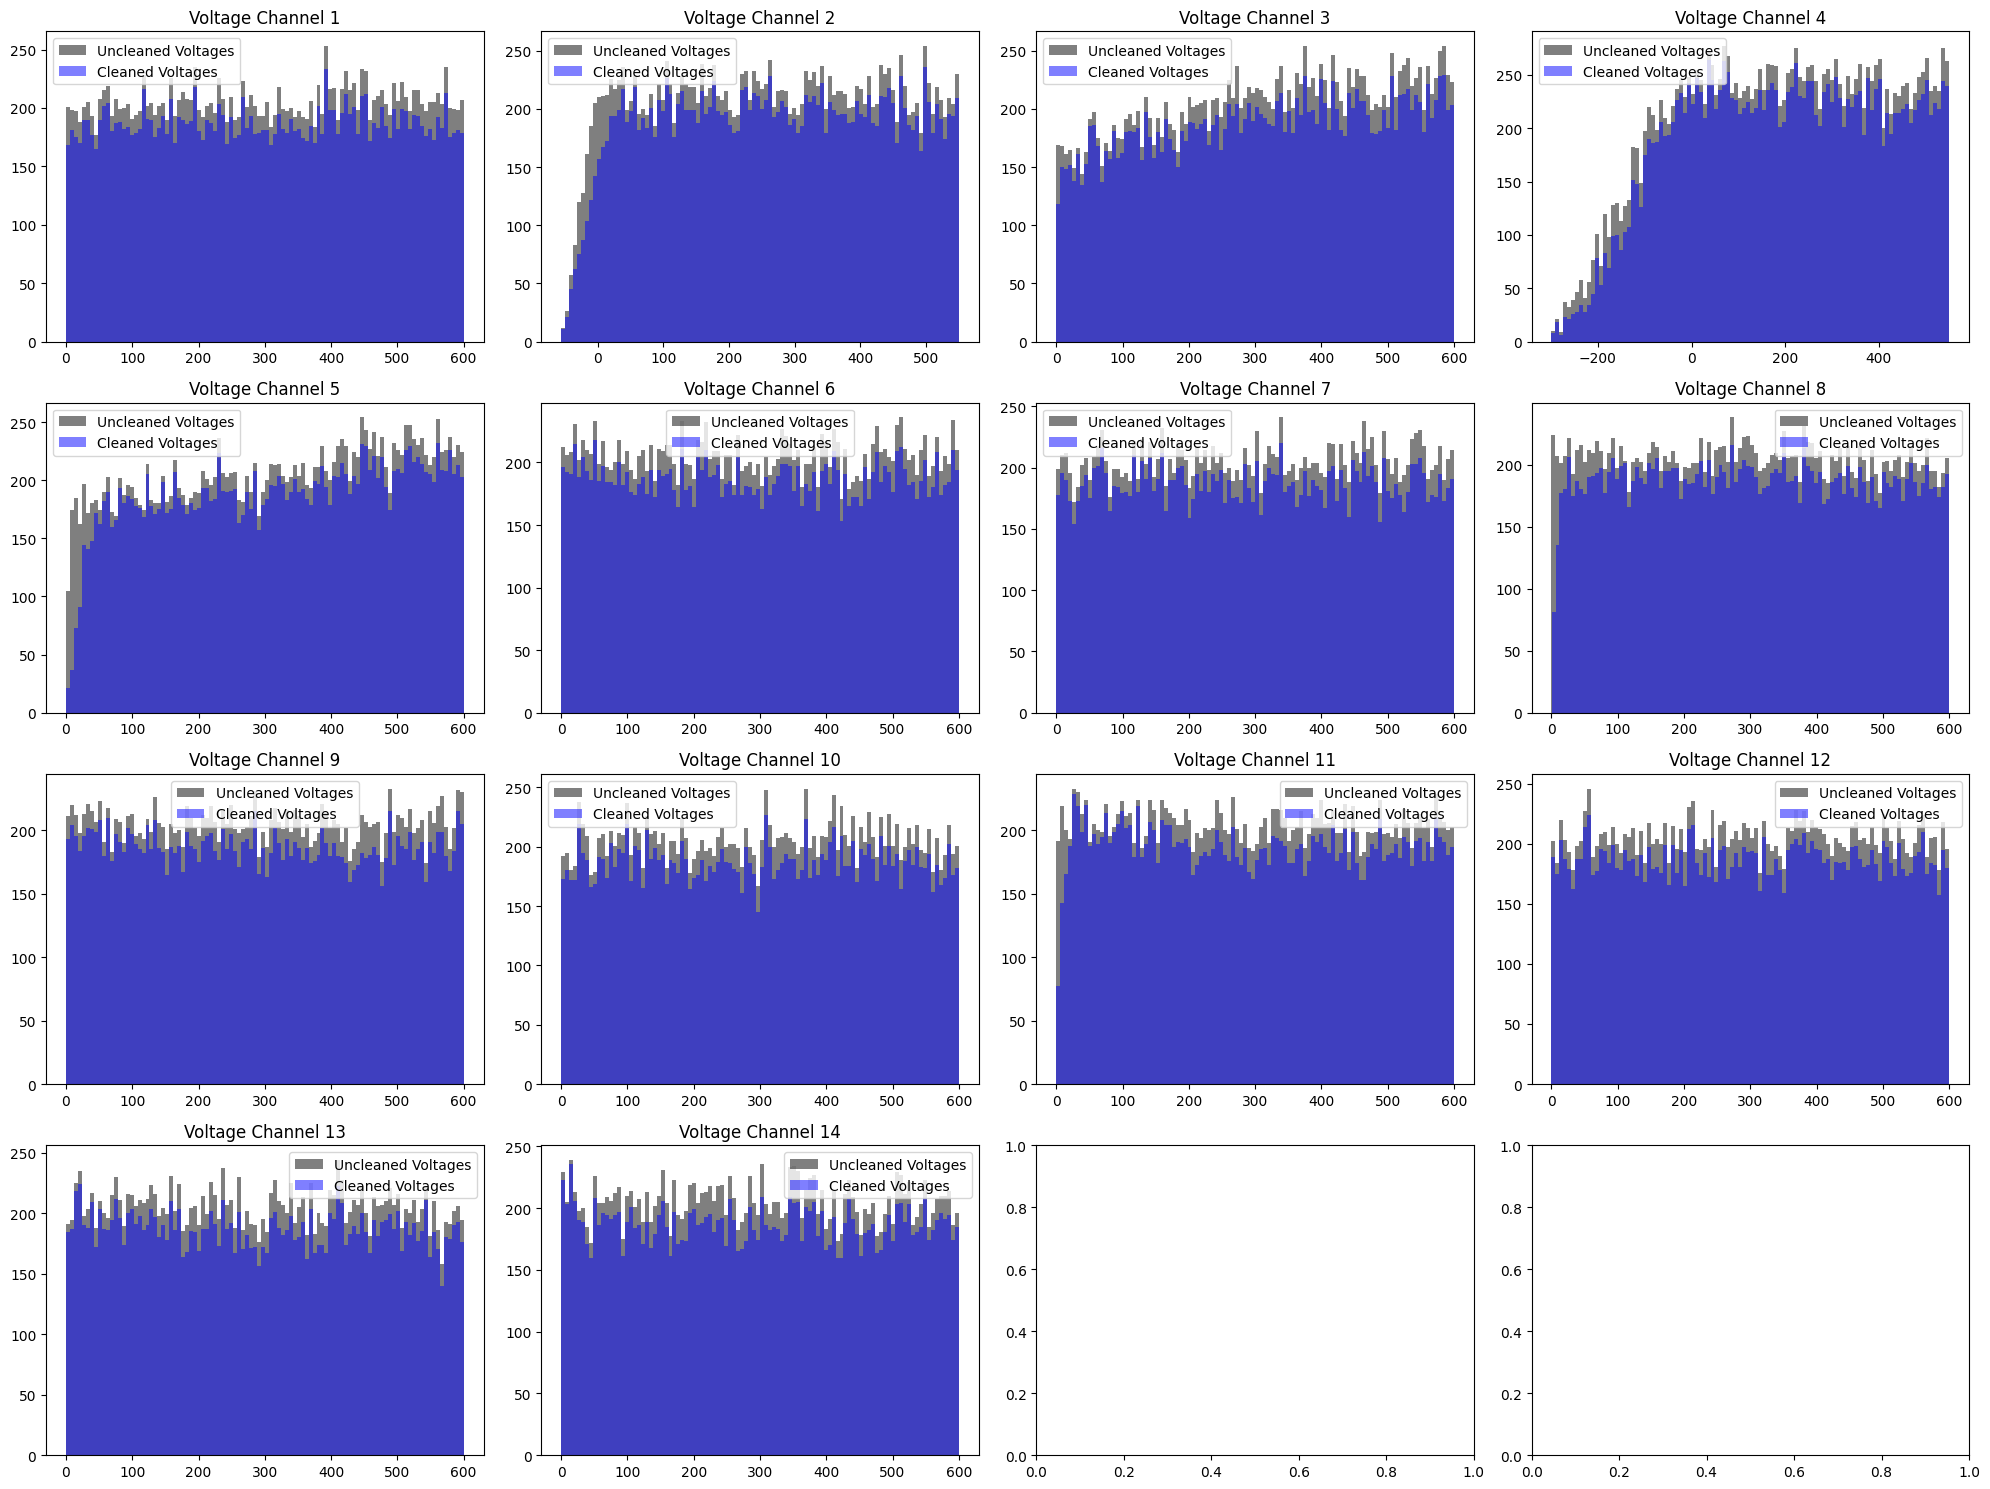

In [258]:
threshold = 1
_,ax,_,_,_,_=trim_scatter(["test_model_data.csv","parallel_test_model_data.csv"], output_values_start=20, output_values_end=21,trim_threshold=threshold,subplot_shape=(1,2),figsize=(20, 5))
# ax[0].set_xlim(0, 100)


_,_,_,_,fig,ax=trim_hist(['test_model_data.csv','parallel_test_model_data.csv'], output_values_start=20, output_values_end=21,trim_threshold=threshold,subplot_shape=(4,4))


Using device: mps
Training model...
Epoch 0: Train Loss = 0.141144, Val Loss = 0.020761
Training completed. Best validation loss: 0.018050


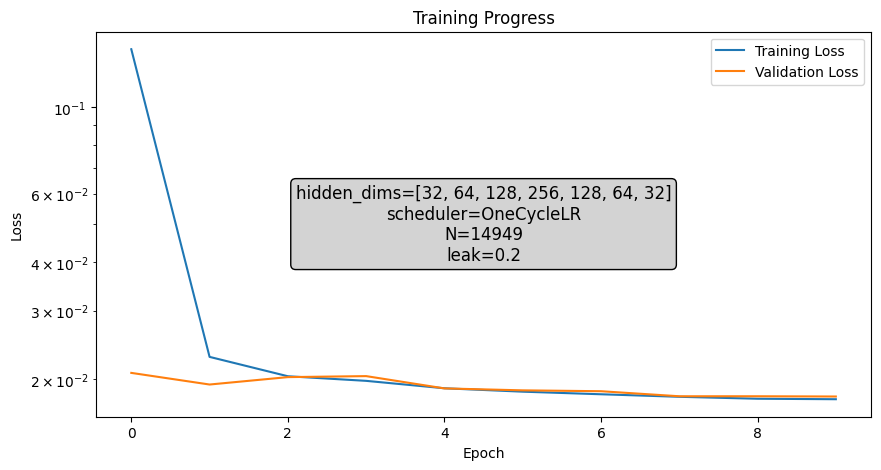

In [254]:

n_voltages = 14     # Number of voltage parameters
n_output_values = 2 # Number of output values (e.g., magnification, aberration, etc.)
voltages, output_values =load_data(['parallel_test_model_data.csv','test_model_data.csv'], output_values_start=20, output_values_end=21,trim_threshold=threshold)
# Create and train model
predictor3 = ElectronOpticsPredictor(input_dim=n_voltages, output_dim=n_output_values,leak=0.2)
print("Training model...")
predictor3.train(voltages, output_values, epochs=10, verbose=True,weight_name='best_model3.pth')


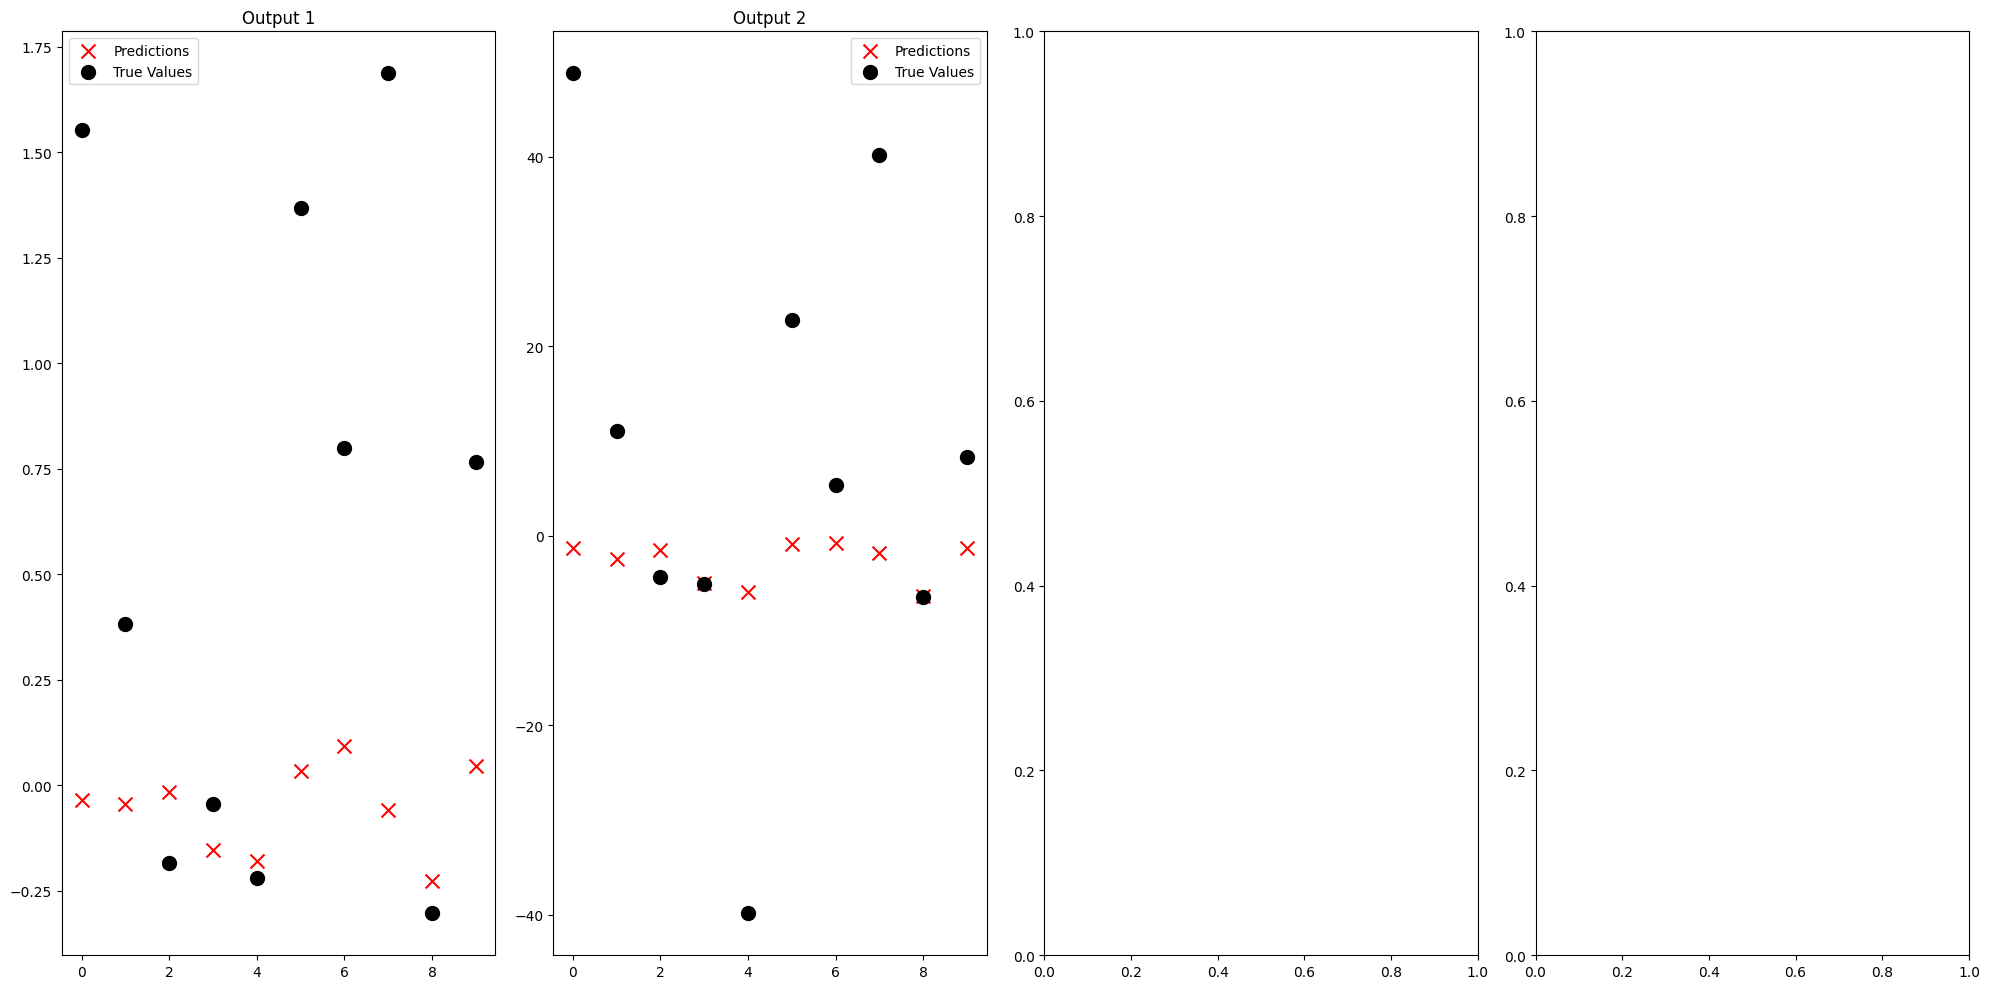

In [259]:
_,_,all_predictions, all_true_values =plot_inference_comparison(predictor3,n_samples=10,subplot_shape=(1,4))

Cluster 4

93.6% of data retained after cleaning


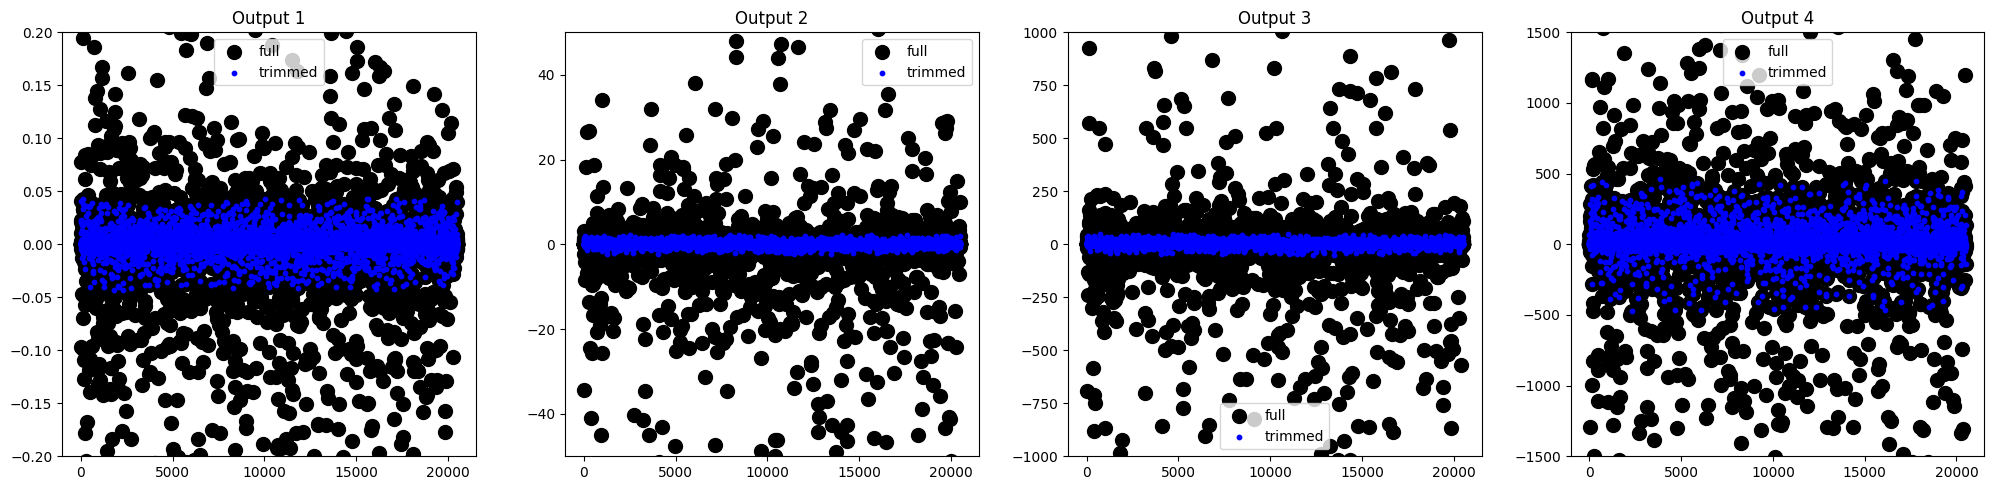

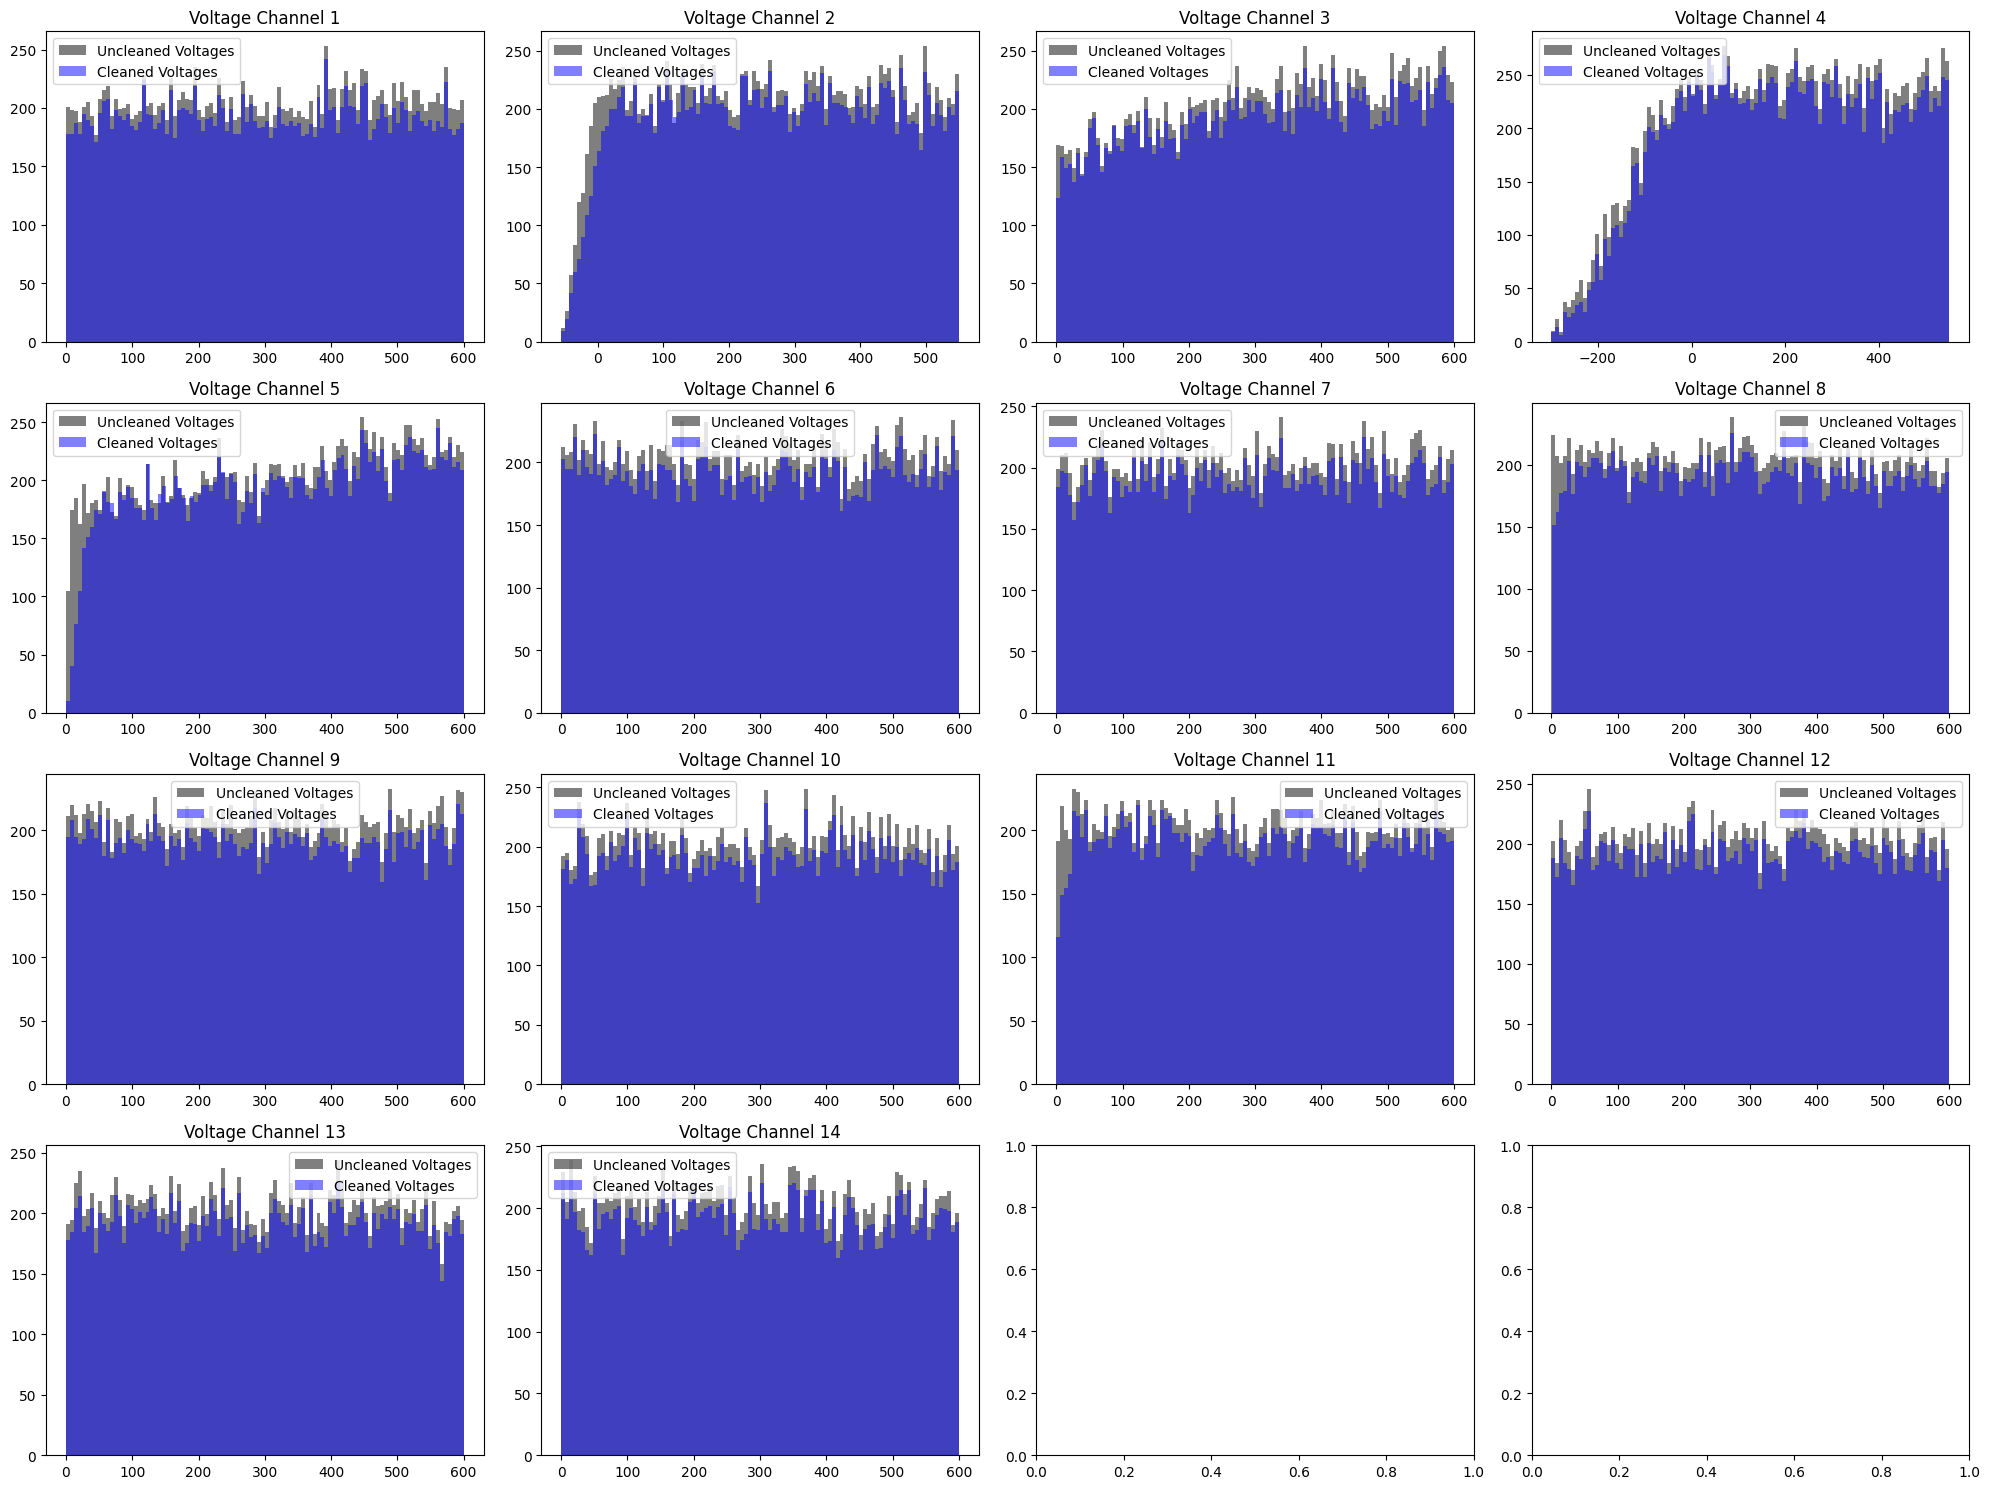

In [27]:
threshold = 60
_,ax,_,_,_,_=trim_scatter(["test_model_data.csv","parallel_test_model_data.csv"], output_values_start=22, output_values_end=25,trim_mode='iqr',trim_threshold=threshold,subplot_shape=(1,4),figsize=(20, 5))
# ax[0].set_xlim(0, 100)
ax[0].set_ylim(-0.2, 0.2)
ax[1].set_ylim(-50, 50)
ax[2].set_ylim(-1000, 1000)
ax[3].set_ylim(-1500, 1500)


_,_,_,_,fig,ax=trim_hist(['test_model_data.csv','parallel_test_model_data.csv'], output_values_start=22, output_values_end=25,trim_mode='iqr',trim_threshold=threshold,subplot_shape=(4,4))


Using device: mps
Training model...
Epoch 0: Train Loss = 0.142039, Val Loss = 0.004288
Training completed. Best validation loss: 0.003505


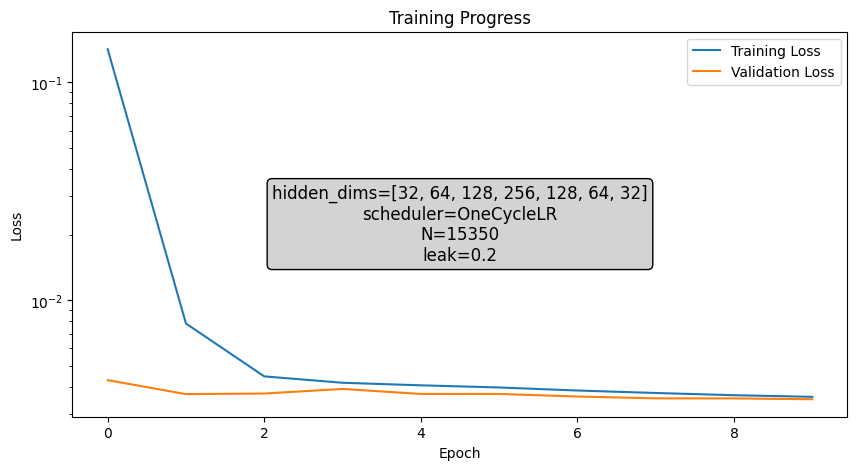

In [31]:

n_voltages = 14     # Number of voltage parameters
n_output_values = 4 # Number of output values (e.g., magnification, aberration, etc.)
voltages, output_values =load_data(['parallel_test_model_data.csv','test_model_data.csv'], output_values_start=22,output_values_end=25,trim_mode='iqr',trim_threshold=threshold)
# Create and train model
predictor4 = ElectronOpticsPredictor(input_dim=n_voltages, output_dim=n_output_values,leak=0.2)
print("Training model...")
predictor4.train(voltages, output_values, epochs=10, verbose=True,weight_name='best_model4.pth')


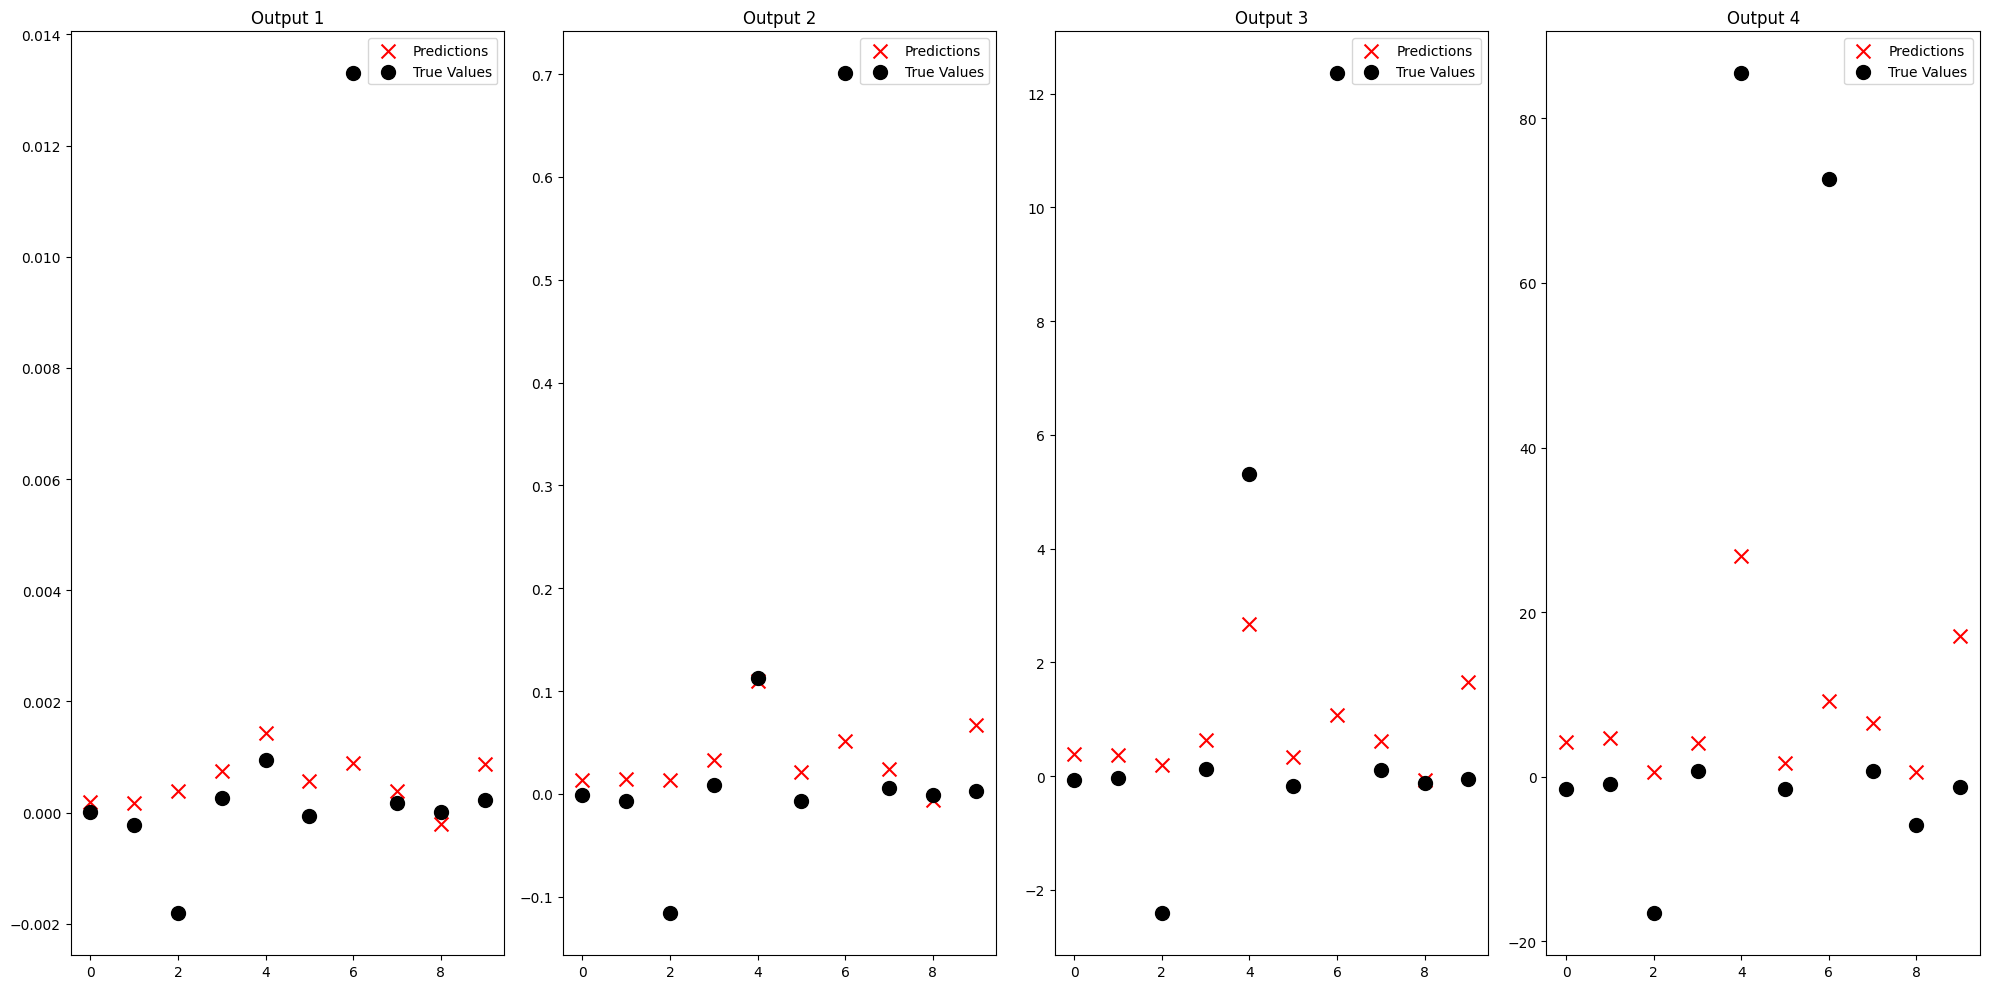

In [32]:
_,_,all_predictions, all_true_values =plot_inference_comparison(predictor4,n_samples=10,subplot_shape=(1,4))